In [54]:
# Libraries
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import requests
import folium
from geopy.distance import geodesic
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from collections import namedtuple
from time import sleep
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import StandardScaler
from kmodes.kprototypes import KPrototypes

# Nursery Schools
### Summary
For this project I would like to analyze the similarities and differences between different schools. Some of the important attributes that I believe are important for parents are the following:

1. Admission policy
    - Public
    - Private
2. Location
    - District (Arrondissement)
    - Neighbourhood (Quartier)
3. Through school (Nursery and Elementary)
4. Has catering service
5. Is part of the priority education program (Not part of the program, REP, REP+)
6. Institution specialized areas
    - Arts
    - Cinema
    - Theater
    - Sport
7. Is part of the enhanced language instruction program
    - Section européenne (Exclusively managed by the national education ministry)
    - Section internationale (Have active participation of foreign partners)
8. Number of students and classroom density
9. Institution age in years
10. Housing information of the area
11. Public transportation services of the area
12. Air quality (I was not able to get this dataset)

From this information I am interested in clustering similar schools together, and from a given school find the n number of schools that are most similar.

### Data Sources
I believe most of this information is publicly available through local and federal open data platforms.
1. [Education Directory](https://data.education.gouv.fr/explore/dataset/fr-en-annuaire-education/information/?disjunctive.identifiant_de_l_etablissement&disjunctive.nom_etablissement&disjunctive.type_etablissement&disjunctive.code_postal&disjunctive.code_commune&disjunctive.nom_commune&disjunctive.code_departement&disjunctive.code_academie&disjunctive.appartenance_education_prioritaire&disjunctive.type_contrat_prive&disjunctive.libelle_departement&disjunctive.libelle_academie&disjunctive.libelle_region&disjunctive.nom_circonscription&disjunctive.ministere_tutelle&disjunctive.code_type_contrat_prive&disjunctive.pial&refine.code_region=75&refine.ecole_maternelle=1): Data on open public and private establishments located in France.
    - Administrative institution number (UAI)
    - Institution Name
    - Institution Type
    - Public/Private
    - Zip Code
    - Municipality Code
    - Municipality Name
    - Department Code
    - Academic Code
    - Region Code
    - Is Kindergarten
    - Is Elementary School
    - Has Catering Service
    - Has Lodging Service
    - Has Inclusive Education Unit
    - Has Arts Section
    - Has Cinema Section
    - Has Theater Section
    - Has Sport Section
    - Has International Section
    - Has European Section
    - Is Priority Education Network (REP), or Reinforced Education Network (REP+)
    - SIRET ID
    - Number of Students
    - If private, contract type
    - Department Label
    - Academic Label
    - Region Label
    - Latitude
    - Longitude
    - Institution Opening Date
    - Updated Date
    - Institution Status
    - Institution with Multiple Sites (Multi UAI)
    - Contract Type ID
- [Student & Class Density](https://data.education.gouv.fr/explore/dataset/fr-en-ecoles-effectifs-nb_classes/table/?disjunctive.rentree_scolaire&disjunctive.region_academique&disjunctive.academie&disjunctive.departement&disjunctive.commune&disjunctive.numero_ecole&disjunctive.denomination_principale&disjunctive.patronyme&disjunctive.secteur&disjunctive.code_postal&sort=tri)
- [Housing Data](https://opendata.paris.fr/explore/dataset/logement-encadrement-des-loyers/information/?disjunctive.annee&disjunctive.id_zone&disjunctive.nom_quartier&disjunctive.piece&disjunctive.epoque&disjunctive.meuble_txt)
- [Google Maps API](https://github.com/googlemaps/google-maps-services-python)

In [2]:
education_directory_raw = pd.read_csv('./data/paris_opendata/annuaire.csv', sep=';')
housing_data = pd.read_csv('./data/paris_opendata/logement.csv',sep=';')
paris_neighbourhoods = pd.read_csv('./data/paris_opendata/quartier_paris.csv', sep=';')
google_maps_public_transport_data = pd.read_csv('./data/paris_opendata/paris_schools_public_transport_info.csv')
schools_density = pd.read_csv('./data/paris_opendata/effectifs_classes.csv', sep=';')

/var/folders/92/dqj9dff15r1990xbnbpww0gw0000gn/T/ipykernel_83689/2722827788.py:1: DtypeWarning: Columns (8,10,19,20,39,41,60,63) have mixed types. Specify dtype option on import or set low_memory=False.
  education_directory_raw = pd.read_csv('./data/paris_opendata/annuaire.csv', sep=';')


## Exploratory Data Analysis

In [3]:
education_directory_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68977 entries, 0 to 68976
Data columns (total 69 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Identifiant_de_l_etablissement        68977 non-null  object 
 1   Nom_etablissement                     68977 non-null  object 
 2   Type_etablissement                    68692 non-null  object 
 3   Statut_public_prive                   66821 non-null  object 
 4   Adresse_1                             68869 non-null  object 
 5   Adresse_2                             6474 non-null   object 
 6   Adresse_3                             56641 non-null  object 
 7   Code postal                           68977 non-null  int64  
 8   Code_commune                          68977 non-null  object 
 9   Nom_commune                           68977 non-null  object 
 10  Code_departement                      68977 non-null  object 
 11  Code_academie  

In [4]:
housing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12800 entries, 0 to 12799
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Année                         12800 non-null  int64  
 1   Secteurs géographiques        12800 non-null  int64  
 2   Numéro du quartier            12800 non-null  int64  
 3   Nom du quartier               12800 non-null  object 
 4   Nombre de pièces principales  12800 non-null  int64  
 5   Epoque de construction        12800 non-null  object 
 6   Type de location              12800 non-null  object 
 7   Loyers de référence           12800 non-null  float64
 8   Loyers de référence majorés   12800 non-null  float64
 9   Loyers de référence minorés   12800 non-null  float64
 10  Ville                         12800 non-null  object 
 11  Numéro INSEE du quartier      12800 non-null  int64  
 12  geo_shape                     12800 non-null  object 
 13  g

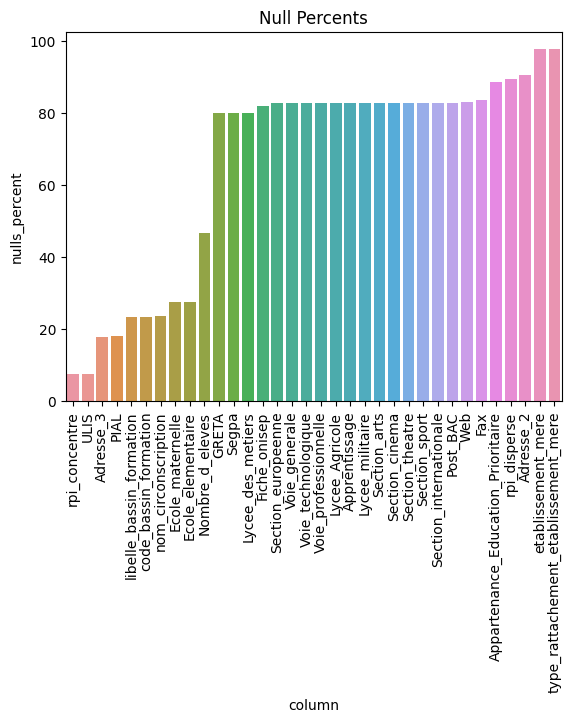

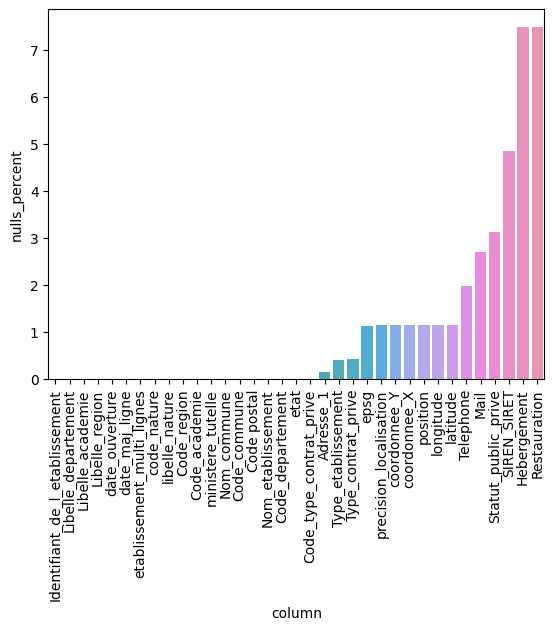

In [5]:
null_pct = education_directory_raw.isna().sum()*100/68977
plt.title('Null Percents')
null_pct = pd.DataFrame({'column':null_pct.index,'nulls_percent':null_pct.values}).sort_values(by='nulls_percent')
sns.barplot(data=null_pct.iloc[-34:,:], x='column',y='nulls_percent')
plt.xticks(rotation=90)
plt.show()
sns.barplot(data=null_pct.iloc[:35,:], x='column',y='nulls_percent')
plt.xticks(rotation=90)
plt.show()

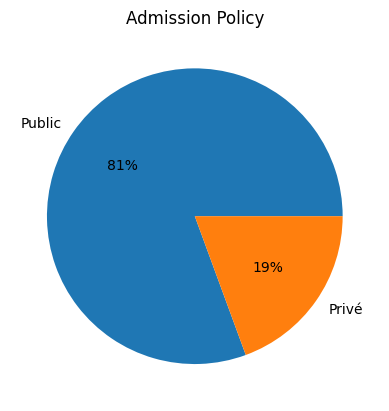

In [6]:
plt.title('Admission Policy')
plt.pie(
    x=education_directory_raw['Statut_public_prive'].value_counts(),
    labels=education_directory_raw['Statut_public_prive'].value_counts().index,
    autopct='%.0f%%',
    
)
plt.show()

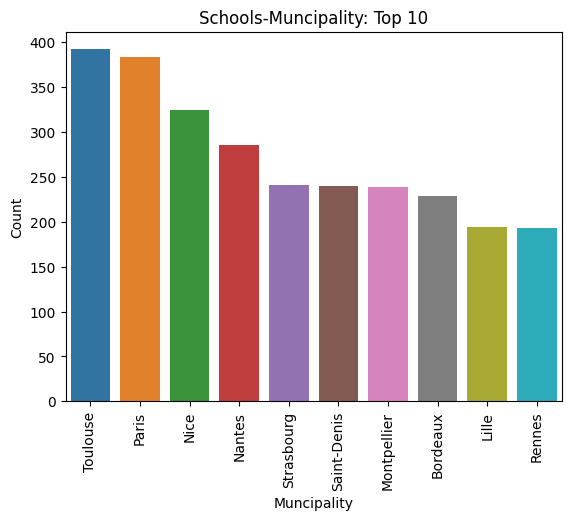

In [7]:
plt.title('Schools-Muncipality: Top 10')
ncom_counts = education_directory_raw['Nom_commune'].value_counts()
ncom_counts = pd.DataFrame({'Muncipality':ncom_counts.index[:10],'Count':ncom_counts.values[:10]})
sns.barplot(data=ncom_counts, x='Muncipality',y='Count', )
plt.xticks(rotation=90)
plt.show()

In [8]:
nursery_types_counts = education_directory_raw[education_directory_raw['libelle_nature'].str.contains('maternelle',case=False)]['libelle_nature'].value_counts()
nursery_types_counts = pd.DataFrame({'Type':nursery_types_counts.index,'Count':nursery_types_counts.values})
nursery_types_counts

,Type,Count
0,ECOLE MATERNELLE,13131
1,ECOLE MATERNELLE D APPLICATION,70
2,ECOLE MATERNELLE ANNEXE D INSPE,1


In [9]:
housing_data.columns

Index(['Année', 'Secteurs géographiques', 'Numéro du quartier',
       'Nom du quartier', 'Nombre de pièces principales',
       'Epoque de construction', 'Type de location', 'Loyers de référence',
       'Loyers de référence majorés', 'Loyers de référence minorés', 'Ville',
       'Numéro INSEE du quartier', 'geo_shape', 'geo_point_2d'],
      dtype='object')

In [10]:
housing_data.sample(3)

,Année,Secteurs géographiques,Numéro du quartier,Nom du quartier,Nombre de pièces principales,Epoque de construction,Type de location,Loyers de référence,Loyers de référence majorés,Loyers de référence minorés,Ville,Numéro INSEE du quartier,geo_shape,geo_point_2d
5715,2022,10,42,Saint-Ambroise,2,1971-1990,non meublé,23.1,27.72,16.17,PARIS,7511142,"{""coordinates"": [[[2.3709396913768344, 48.8577...","48.862345023544634, 2.3761180559189894"
1147,2023,9,46,Picpus,1,Avant 1946,meublé,31.1,37.30,21.80,PARIS,7511246,"{""coordinates"": [[[2.4112497331364513, 48.8296...","48.83035924236651, 2.428826815083848"
8333,2020,2,21,Monnaie,1,1971-1990,meublé,31.5,37.80,22.05,PARIS,7510621,"{""coordinates"": [[[2.343168550439539, 48.85138...","48.85438440363994, 2.3400353711305164"


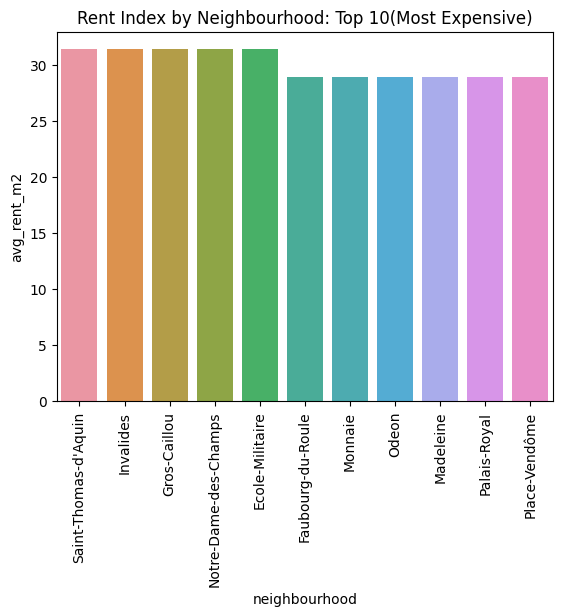

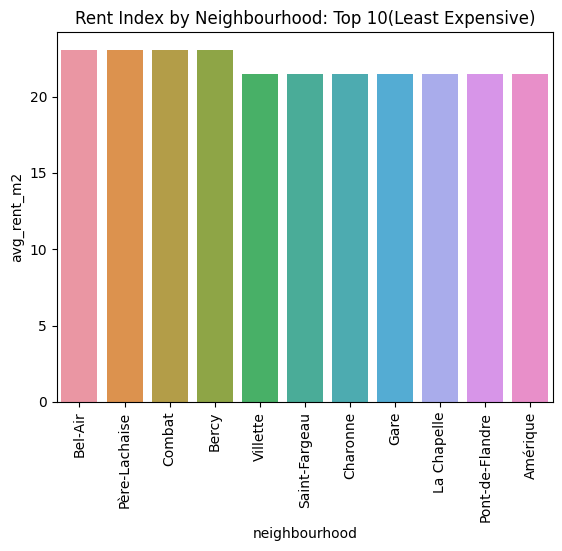

In [11]:
housing_data_2023 = housing_data[housing_data['Année'] == 2023]
rent_index_mean = housing_data_2023[
    ['Nom du quartier','Loyers de référence','Numéro du quartier']
].groupby(
    ['Nom du quartier']
).mean().sort_values(by='Loyers de référence', ascending=False)
rent_index_mean.rename(columns={'Nom du quartier': 'neighbourhood','Numéro du quartier':'neighbourhood_number','Loyers de référence':'rent_index'}, inplace=True)
rent_index_mean_data = pd.DataFrame({
    'neighbourhood': rent_index_mean.index, 
    'avg_rent_m2':rent_index_mean['rent_index'].values 
})
plt.title('Rent Index by Neighbourhood: Top 10(Most Expensive)')
sns.barplot(data=rent_index_mean_data.iloc[:11,:], x='neighbourhood', y='avg_rent_m2')
plt.xticks(rotation=90)
plt.show()
plt.title('Rent Index by Neighbourhood: Top 10(Least Expensive)')
sns.barplot(data=rent_index_mean_data.iloc[-11:,:], x='neighbourhood', y='avg_rent_m2')
plt.xticks(rotation=90)
plt.show()

In [12]:
# Pre Processed Google Data, see code in pre-processing section
google_maps_public_transport_data.sample(5)

,index,name,closest_station_name,distance,id
676,48837,E.E.PR CONCORDIA BILINGUAL SCHOOL 41 avenue de...,Kléber,0.517629,0756007X
373,21785,E.P.PU ST MARTIN 211 rue Saint Martin,Arts et Métiers,0.284870,0751002G
592,48753,E.E.PU WATTIGNIES 52 rue de Wattignies,Gare de Lyon,1.935104,0751243U
591,48752,E.E.PU VOLTAIRE 8 cité Voltaire,Austerlitz,2.161726,0751241S
56,7410,E.E.A.PU LA FONTAINE 41 bis rue la Fontaine,La Muette,0.616784,0751135B


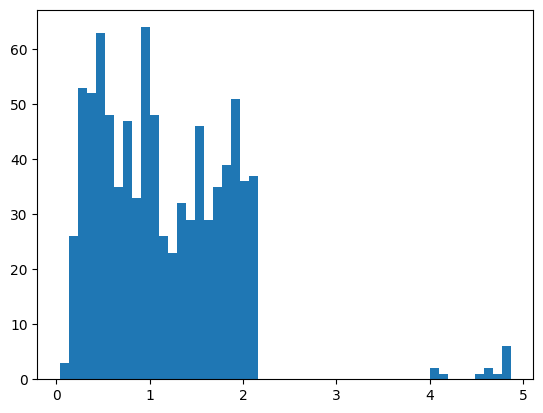

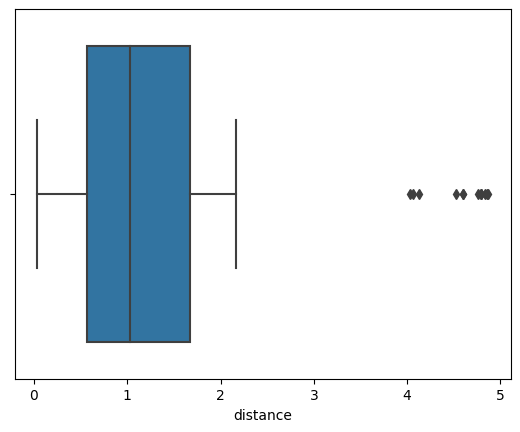

In [13]:
plt.hist(list(google_maps_public_transport_data['distance']), bins=50)
plt.show()
sns.boxplot(x=google_maps_public_transport_data['distance'])
plt.show()

In [14]:
schools_density.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194898 entries, 0 to 194897
Data columns (total 23 columns):
 #   Column                                        Non-Null Count   Dtype 
---  ------                                        --------------   ----- 
 0   Rentrée scolaire                              194898 non-null  int64 
 1   Région académique                             194898 non-null  object
 2   Académie                                      194898 non-null  object
 3   Département                                   194898 non-null  object
 4   Commune                                       194898 non-null  object
 5   Numéro de l'école                             194898 non-null  object
 6   Dénomination principale                       194897 non-null  object
 7   Patronyme                                     148531 non-null  object
 8   Secteur                                       194898 non-null  object
 9   REP                                           194898 non-nu

In [15]:
schools_density.sample(3)

,Rentrée scolaire,Région académique,Académie,Département,Commune,Numéro de l'école,Dénomination principale,Patronyme,Secteur,REP,...,Nombre d'élèves en pré-élémentaire hors ULIS,Nombre d'élèves en élémentaire hors ULIS,Nombre d'élèves en ULIS,Nombre d'élèves en CP hors ULIS,Nombre d'élèves en CE1 hors ULIS,Nombre d'élèves en CE2 hors ULIS,Nombre d'élèves en CM1 hors ULIS,Nombre d'élèves en CM2 hors ULIS,tri,Code Postal
184522,2019,OCCITANIE,MONTPELLIER,AUDE,ARZENS,0110861B,ECOLE PRIMAIRE PUBLIQUE,SIMONE VEIL,PUBLIC,0,...,35,71,0,8,14,15,17,17,81-OCCITANIE-MONTPELLIER-AUDE-ARZENS-0110861B,11290
18124,2022,HAUTS-DE-FRANCE,AMIENS,AISNE,BOURG-ET-COMIN,0020143V,ECOLE PRIMAIRE PUBLIQUE,NaN,PUBLIC,0,...,46,85,0,12,14,20,19,20,78-HAUTS-DE-FRANCE-AMIENS-AISNE-BOURG-ET-COMIN...,2160
192887,2019,PROVENCE-ALPES-COTE-D'AZUR,AIX-MARSEILLE,BOUCHES-DU-RHONE,MARSEILLE 15E ARRONDISSEMENT,0130938Z,ECOLE MATERNELLE PUBLIQUE,SAINT LOUIS LEVEQUE,PUBLIC,0,...,156,0,0,0,0,0,0,0,81-PROVENCE-ALPES-COTE-D'AZUR-AIX-MARSEILLE-BO...,13015


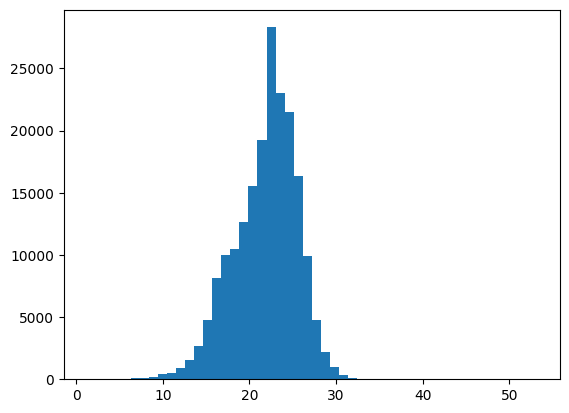

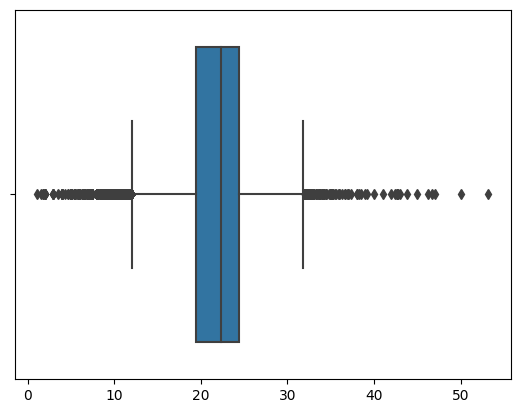

In [16]:
# Student Density = Total number of students/Classes
plt.hist(list(schools_density["Nombre total d'élèves"]/schools_density['Nombre total de classes']), bins=50)
plt.show()
sns.boxplot(x=list(schools_density["Nombre total d'élèves"]/schools_density['Nombre total de classes']))
plt.show()

## Data Pre-Processing

In [17]:
#CONSTANTS
GOOGLE_MAPS_ENDPOINT = 'https://maps.googleapis.com/maps/api/place/nearbysearch/json?'
G_API_KEY = None

with open('./api_keys/keys.json','r') as file:
    G_API_KEY = json.loads(file.read())['g']

#HELPERS
def get_distance(lat_long_a: tuple, lat_long_b: tuple):
        return geodesic(lat_long_a, lat_long_b).km

#CLASSES
class Station:
    def __init__(self, name, lat, long, radius=5000):
        self.name = name
        self.lat = lat
        self.long = long
        self.radius = radius
        self.stations = None
        self.closest_station = None
        self.closest_station_name = None
        self.closest_distance = None
        self.call_google()
        
    
    
    def call_google(self):
        url = f'{GOOGLE_MAPS_ENDPOINT}location={self.lat}%2C{self.long}&radius={self.radius}&type=subway_station|train_station&key={G_API_KEY}'
        payload={}
        headers = {}
        response = json.loads(requests.request("GET", url, headers=headers, data=payload).text)
        self.stations = response['results']
        if (len(self.stations)):
            try:
                self.closest_station = self.stations[0]
                location = self.closest_station['geometry']['location']
                self.closest_distance = get_distance((self.lat, self.long),(location['lat'], location['lng']))
                self.closest_station_name = self.stations[0]['name']
            except Exception as e:
                print(f'Error getting dictance {e}')
# Filter Paris Region, School Types
class Drop_Columns(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop: list = None) -> None:
        self.X = None
        self.y = None
        self.columns_to_drop = columns_to_drop

    def fit(self, X: pd.DataFrame, y: pd.DataFrame = None) -> None:
        self.X = X
        self.y = y
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        return self.X.drop(columns=self.columns_to_drop) if self.columns_to_drop else self.X

class Rename_Columns(BaseEstimator, TransformerMixin):
    def __init__(self, column_name_map: dict = None) -> None:
        self.X = None
        self.y = None
        self.column_name_map = column_name_map

    def fit(self, X: pd.DataFrame, y: pd.DataFrame = None) -> None:
        self.X = X
        self.y = y
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        return self.X.rename(columns=self.column_name_map) if self.column_name_map else self.X

class Set_Data_Types(BaseEstimator, TransformerMixin):
    def __init__(self, column_type_map) -> None:
        self.X = None
        self.y = None
        self.column_type_map = column_type_map

    def fit(self, X: pd.DataFrame, y: pd.DataFrame = None) -> None:
        self.X = X
        self.y = y
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        return self.X.astype(self.column_type_map) if self.column_type_map else self.X

class DF_Filter(BaseEstimator, TransformerMixin):
    def __init__(self, statement: str) -> None:
        self.X = None
        self.y = None
        self.statement = statement

    def fit(self, X: pd.DataFrame, y: pd.DataFrame = None):
        self.X = X
        self.y = y
        return self
    
    def transform(self, X: pd.DataFrame)->pd.DataFrame:
        return X.query(self.statement)
    
class DF_Fill_NA(BaseEstimator, TransformerMixin):
    def __init__(self, column: str, value) -> None:
        self.X = None
        self.y = None
        self.column = column
        self.value = value

    def fit(self, X: pd.DataFrame, y: pd.DataFrame = None):
        self.X = X
        self.y = y
        return self
    
    def transform(self, X: pd.DataFrame)->pd.DataFrame:
        X[self.column] = X[self.column].fillna(self.value)
        return X

class Replace_Column_Values(BaseEstimator, TransformerMixin):
    def __init__(self, column: str, value_map: dict) -> None:
        self.X = None
        self.y = None
        self.column = column
        self.value_map = value_map

    def fit(self, X: pd.DataFrame, y: pd.DataFrame = None):
        self.X = X
        self.y = y
        return self
    
    def transform(self, X: pd.DataFrame)->pd.DataFrame:
        X[self.column] = X[self.column].replace(to_replace=self.value_map)
        return X

class Basic_Transformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop: list = None, column_name_map: dict = None, column_type_map: dict = None) -> None:
        self.X = None
        self.y = None
        self.columns_to_drop = columns_to_drop
        self.column_name_map = column_name_map
        self.column_type_map = column_type_map

    def fit(self, X: pd.DataFrame, y: pd.DataFrame = None):
        self.X = X
        self.y = y
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        return Pipeline([
            ('drop_columns', Drop_Columns(self.columns_to_drop)),
            ('rename_columns', Rename_Columns(self.column_name_map)),
            ('set_data_types', Set_Data_Types(self.column_type_map))
        ]).fit_transform(X=self.X, y=self.y)


I will make a first join of the school density and education directory.

In [18]:
education_directory_raw_copy = education_directory_raw.rename(columns={"Identifiant_de_l_etablissement":'id'},inplace=False)
education_directory_raw_copy = education_directory_raw_copy.set_index(keys=['id'],inplace=False)
schools_density_copy = schools_density.rename(columns={"Numéro de l'école":"id"},inplace=False)
schools_density_copy = schools_density_copy.set_index(keys=['id'],inplace=False)
schools_density_copy = schools_density_copy[schools_density_copy['Rentrée scolaire']==2022]
education_dir_w_density = pd.merge(education_directory_raw_copy,schools_density_copy,on='id',how='inner')
education_dir_w_density

,Nom_etablissement,Type_etablissement,Statut_public_prive,Adresse_1,Adresse_2,Adresse_3,Code postal,Code_commune,Nom_commune,Code_departement,...,Nombre d'élèves en pré-élémentaire hors ULIS,Nombre d'élèves en élémentaire hors ULIS,Nombre d'élèves en ULIS,Nombre d'élèves en CP hors ULIS,Nombre d'élèves en CE1 hors ULIS,Nombre d'élèves en CE2 hors ULIS,Nombre d'élèves en CM1 hors ULIS,Nombre d'élèves en CM2 hors ULIS,tri,Code Postal
id,,,,,,,,,,,,,,,,,,,,,
0131913J,Ecole maternelle Roger Le Guérec,Ecole,Public,Avenue Marcel Camusso,NaN,13600 LA CIOTAT,13600,13028,La Ciotat,13,...,66,0,0,0,0,0,0,0,78-PROVENCE-ALPES-COTE-D'AZUR-AIX-MARSEILLE-BO...,13600
0131928A,Ecole maternelle Les Lierres,Ecole,Public,50 avenue 24-avr-15,NaN,13012 MARSEILLE,13012,13212,Marseille 12e Arrondissement,13,...,67,0,0,0,0,0,0,0,78-PROVENCE-ALPES-COTE-D'AZUR-AIX-MARSEILLE-BO...,13012
0131985M,Ecole primaire privée Sainte Anne,Ecole,Privé,18 rue Thieux,NaN,13008 MARSEILLE,13008,13208,Marseille 8e Arrondissement,13,...,88,144,0,29,28,30,28,29,78-PROVENCE-ALPES-COTE-D'AZUR-AIX-MARSEILLE-BO...,13008
0131998B,Ecole élémentaire La Salle,Ecole,Public,Rue Victor Hugo,NaN,13320 BOUC BEL AIR,13320,13015,Bouc-Bel-Air,13,...,0,278,0,56,59,55,50,58,78-PROVENCE-ALPES-COTE-D'AZUR-AIX-MARSEILLE-BO...,13320
0132034R,Ecole primaire privée Notre-Dame,Ecole,Privé,2 chemin des Ecoles,NaN,13570 BARBENTANE,13570,13010,Barbentane,13,...,56,80,0,13,17,16,16,18,78-PROVENCE-ALPES-COTE-D'AZUR-AIX-MARSEILLE-BO...,13570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9760288J,Ecole élémentaire de Cavani Sud 2,Ecole,Public,Cavani Sud 2 CAVANI SUD 2,NaN,97600 MAMOUDZOU,97600,97611,Mamoudzou,976,...,0,382,9,87,78,56,54,107,78-MAYOTTE-MAYOTTE-MAYOTTE-MAMOUDZOU-9760288J,97600
9760312K,Ecole élémentaire publique Annexe,Ecole,Public,Rue LYCEE YOUNOUSSA BAMANA MAMOUDZOU,NaN,97600 MAMOUDZOU,97600,97611,Mamoudzou,976,...,0,311,8,100,107,104,0,0,78-MAYOTTE-MAYOTTE-MAYOTTE-MAMOUDZOU-9760312K,97600
9760347Y,Ecole élémentaire de Kawéni T17,Ecole,Public,Rue du stade Kawéni face clg Kawéni1 KAWENI,NaN,97600 MAMOUDZOU,97600,97611,Mamoudzou,976,...,0,497,0,95,95,112,111,84,78-MAYOTTE-MAYOTTE-MAYOTTE-MAMOUDZOU-9760347Y,97600


I will focus my analysis on the area of Paris and elementary/primary education data, since it is my main interest. I will also drop 3 schools without geolocation info.

In [19]:
df_filter = (education_dir_w_density['Type_etablissement'] == 'Ecole') & \
(((education_dir_w_density['Code postal'] == 78100) | (education_dir_w_density['Code postal'] == 78112)) | \
((education_dir_w_density['Code postal'] >= 75000) & (education_dir_w_density['Code postal'] < 76000)))
paris_school_data = education_dir_w_density[df_filter]
paris_school_data = paris_school_data.rename(columns={"Identifiant_de_l_etablissement":"id"})
paris_school_data = paris_school_data.drop(paris_school_data[paris_school_data['longitude'].isna()].index)
paris_school_data = paris_school_data.reset_index()
paris_school_data.sample(3)

,id,Nom_etablissement,Type_etablissement,Statut_public_prive,Adresse_1,Adresse_2,Adresse_3,Code postal,Code_commune,Nom_commune,...,Nombre d'élèves en pré-élémentaire hors ULIS,Nombre d'élèves en élémentaire hors ULIS,Nombre d'élèves en ULIS,Nombre d'élèves en CP hors ULIS,Nombre d'élèves en CE1 hors ULIS,Nombre d'élèves en CE2 hors ULIS,Nombre d'élèves en CM1 hors ULIS,Nombre d'élèves en CM2 hors ULIS,tri,Code Postal
398,0752334E,E.E.PU CAVE 11 rue Cave,Ecole,Public,11 rue Cave,NaN,75018 PARIS,75018,75118,Paris 18e Arrondissement,...,0,103,0,23,24,22,17,17,78-ILE-DE-FRANCE-PARIS-PARIS-PARIS 18E ARROND...,75018
9,0750227P,E.P.PR SAINT-AMBROISE 11 passage Saint Ambroise,Ecole,Privé,11 passage Saint Ambroise,NaN,75011 PARIS,75011,75111,Paris 11e Arrondissement,...,86,142,0,28,27,29,30,28,78-ILE-DE-FRANCE-PARIS-PARIS-PARIS 11E ARROND...,75011
124,0753059T,E.E.PR BETH HANNA 49 rue Petit,Ecole,Privé,49 rue Petit,NaN,75019 PARIS,75019,75119,Paris 19e Arrondissement,...,0,445,5,96,92,93,84,80,78-ILE-DE-FRANCE-PARIS-PARIS-PARIS 19E ARROND...,75019


#### Assigning Quartier to Paris Schools
We will need to join the housing data with the education directory data as part of pre-processing. Since we don't have a direct relation between the two dataframes we will need to calculate if the latitudes and longitudes of each school (in Paris) is within the polygons in the paris neighbourhoods data set, and insert this information to the education directory dataframe using the shapely package.

In [20]:
school_quartier_pointer = namedtuple("SchoolPointer", "school_id quartier_id quartier_name")
paris_neighbourhoods_geometry = paris_neighbourhoods[['Geometry']]['Geometry'].apply(lambda c: np.array(json.loads(c)['coordinates'][0]))
paris_neighbourhoods_polygons = [Polygon(np.array([polygons.T[1],polygons.T[0]]).T) for polygons in paris_neighbourhoods_geometry]

paris_schools_geolocation = paris_school_data.iloc[:,[0,51,52]]
paris_schools_points = [(id_, Point(lat, long)) for (id_, lat,long) in np.array(paris_schools_geolocation)]


paris_schools_quartiers_pointers = []
for school_id, point in paris_schools_points:
    match = False
    for idx_polygon, polygon in enumerate(paris_neighbourhoods_polygons):
        is_within = point.within(polygon)
        if(is_within):
            q_id, q_name = tuple(paris_neighbourhoods.iloc[idx_polygon,[1,3]].values)
            paris_schools_quartiers_pointers.append(school_quartier_pointer(school_id, q_id, q_name))
            match = True
    if(not match):
        paris_schools_quartiers_pointers.append(school_quartier_pointer(school_id, -1, 'Saint-Germain-en-Laye'))
paris_schools_quartiers_pointers[:3]

[SchoolPointer(school_id='0750150F', quartier_id=17, quartier_name='Saint-Victor'),
 SchoolPointer(school_id='0750225M', quartier_id=41, quartier_name='Folie-Méricourt'),
 SchoolPointer(school_id='0752973Z', quartier_id=50, quartier_name='Gare')]

#### Public Transport Options of the Area

We will use the Google Maps API to get the nearest subway or train station in KM to each Paris' school in the education directory.
The code in this section is commented, so we don't call Google's API's on every notebook run, but the data is saved as csv.

In [21]:
check = [151, 152, 153, 293, 294, 295, 296, 442, 443, 444, 445, 446, 606, 607,608, 609, 610, 611, 612,764,765,766,777,768,769]
school_geo_location = namedtuple('Geolocation','name lat long')
schools_public_transport_info = []
schools_geolocs = [school_geo_location(school[0], school[1], school[2]) for school in list(paris_school_data[['Nom_etablissement','latitude','longitude']].values)]
for school in schools_geolocs:
    try:
        #station = Station(school.name, school.lat, school.long)
        #schools_public_transport_info.append(station)
        pass
    except Exception as e:
        print(e)

In [22]:
#schools_public_transport_summary = pd.DataFrame(
#    [np.array([s.name, s.closest_station_name, s.closest_distance]) for s in schools_public_transport_info], 
#    columns=['name', 'closest_station_name','distance'],
#    index = paris_school_data.index
#)
#schools_public_transport_summary['id'] = list(paris_school_data['id'].values)
#schools_public_transport_summary
#schools_public_transport_summary.to_csv('./data/paris_opendata/paris_schools_public_transport_info.csv')
google_maps_public_transport_data.sample(5)

,index,name,closest_station_name,distance,id
836,62565,E.E.PU CHAMPERRET 7 avenue de la Porte Champerret,Louise Michel,0.305502,0754322R
33,7387,E.E.PU LEPIC 62 rue Lepic,Anvers,0.868042,0750923W
470,21882,E.P.PU SIBELLE 13 avenue de la Sibelle,Denfert-Rochereau,1.006240,0754982H
468,21880,E.M.PU GEORGES THILL 11 rue Georges Thill,Laumière,0.703857,0754941N
859,62588,E.M.PR AT MONTESSORI BABYLONE 24 rue de Babylone,Ségur,1.216093,0756396V


Now let's merge all our data into a single data frame. I will set the average rent price as the median for "Saint Gemrain en Laye" since it's outside of Paris, and actually, it looks like it isn't far (https://immobilier.lefigaro.fr/prix-immobilier/saint-germain-en-laye/ville-78551#loyer-m2)

In [23]:
paris_school_data_ = paris_school_data.copy()
public_transport_data = google_maps_public_transport_data.copy()
df_raw = pd.merge(paris_school_data_,public_transport_data, on='id', how='inner')
paris_schools_neighbourhoods = pd.DataFrame(paris_schools_quartiers_pointers, 
    columns=['id','neighbourhood_number','neighbourhood_name']
)
df_raw = pd.merge(df_raw, paris_schools_neighbourhoods, on='id', how='inner')
df_raw = pd.merge(df_raw, rent_index_mean, on='neighbourhood_number', how='left')
df_raw['rent_index'] = df_raw['rent_index'].fillna(df_raw['rent_index'].mean())
df_raw['age'] = (datetime.now()-pd.to_datetime(df_raw['date_ouverture'])).apply(lambda d: d.total_seconds()/3.154e+7)
df_raw['density'] = df_raw["Nombre total d'élèves"]/df_raw['Nombre total de classes']
df_raw.sample(3)

,id,Nom_etablissement,Type_etablissement,Statut_public_prive,Adresse_1,Adresse_2,Adresse_3,Code postal,Code_commune,Nom_commune,...,Code Postal,index,name,closest_station_name,distance,neighbourhood_number,neighbourhood_name,rent_index,age,density
152,0780498T,Ecole maternelle Alsace,Ecole,Public,26 rue de Noailles,NaN,78100 ST GERMAIN EN LAYE,78100,78551,Saint-Germain-en-Laye,...,78100,7993,Ecole maternelle Alsace,Saint-Germain-en-Laye,0.393199,-1,Saint-Germain-en-Laye,24.992118,51.932836,26.800000
341,0751020B,E.E.PU JOSSEAUME 3 passage Josseaume,Ecole,Public,3 passage Josseaume,NaN,75020 PARIS,75020,75120,Paris 20e Arrondissement,...,75020,21790,E.E.PU JOSSEAUME 3 passage Josseaume,Porte de Montreuil,0.574924,80,Charonne,21.478125,58.332025,22.888889
485,0750911H,E.E.PU JOSEPH DE MAISTRE H 29 rue Joseph de Ma...,Ecole,Public,29 rue Joseph de Maistre,NaN,75018 PARIS,75018,75118,Paris 18e Arrondissement,...,75018,48708,E.E.PU JOSEPH DE MAISTRE H 29 rue Joseph de Ma...,Guy Môquet,0.292239,69,Grandes-Carrières,24.121875,58.332025,21.636364


And let's rename columns, set data types and drop columns that we will not be using:

In [24]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 770 entries, 0 to 769
Data columns (total 100 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            770 non-null    object 
 1   Nom_etablissement                             770 non-null    object 
 2   Type_etablissement                            770 non-null    object 
 3   Statut_public_prive                           770 non-null    object 
 4   Adresse_1                                     770 non-null    object 
 5   Adresse_2                                     0 non-null      object 
 6   Adresse_3                                     770 non-null    object 
 7   Code postal                                   770 non-null    int64  
 8   Code_commune                                  770 non-null    object 
 9   Nom_commune                                   770 non-null    ob

In [25]:
df_cleaner = Basic_Transformer(columns_to_drop=[
    'Adresse_2',
    'Adresse_3',
    'Code_departement',
    'Code_academie',
    'Code_region',
    'Ecole_maternelle',
    'Ecole_elementaire',
    'Voie_generale',
    'Voie_technologique',
    'Voie_professionnelle',
    'Telephone',
    'Fax',
    'Web',
    'Mail',
    'Libelle_academie',
    'Libelle_region',
    'Apprentissage',
    'Segpa',
    'Lycee_Agricole',
    'Lycee_militaire',
    'Lycee_des_metiers',
    'Post_BAC',
    'GRETA',
    'SIREN_SIRET',
    'Fiche_onisep',
    'position',
    'coordonnee_X',
    'coordonnee_Y',
    'epsg',
    'nom_circonscription',
    'precision_localisation',
    'ministere_tutelle',
    'rpi_concentre',
    'rpi_disperse',
    'code_nature',
    'libelle_nature',
    'PIAL',
    'etablissement_mere',
    'type_rattachement_etablissement_mere',
    'code_bassin_formation',
    'libelle_bassin_formation',
    'Nombre_d_eleves',
    'Type_contrat_prive',
    'Code_type_contrat_prive',
    "Nombre d'élèves en pré-élémentaire hors ULIS",
    "Nombre d'élèves en élémentaire hors ULIS", 
    "Nombre d'élèves en ULIS",
    "Nombre d'élèves en CP hors ULIS", 
    "Nombre d'élèves en CE1 hors ULIS",
    "Nombre d'élèves en CE2 hors ULIS", 
    "Nombre d'élèves en CM1 hors ULIS",
    "Nombre d'élèves en CM2 hors ULIS",
    'tri', 
    'latitude', 
    'longitude',
    'date_ouverture',
    'date_maj_ligne',
    'Rentrée scolaire',
    'Région académique',
    'Académie',
    'Département',
    'Patronyme',
    'Nombre total de classes',
    "Nombre total d'élèves",
    'Libelle_departement'],
    column_name_map={
        'Identifiant_de_l_etablissement': 'uai',
        'Nom_etablissement': 'institution_name',
        'Type_etablissement': 'institution_type',
        'Statut_public_prive': 'public_private_status',
        'Adresse_1': 'address',
        'Code postal': 'zip_code',
        'Code_commune': 'municipality_code',
        'Nom_commune': 'municipality_name',
        'Restauration': 'has_catering_service',
        'Hebergement': 'has_lodging_service',
        'ULIS': 'has_inclusive_education',
        'etat': 'institution_status',
        'etablissement_multi_lignes': 'is_multi_uai',
        'Dénomination principale':'main_denomination'
    },
    column_type_map={
        'institution_type': 'category',
        'public_private_status': 'category',
        'institution_type': 'category',
        'public_private_status': 'category',
        'zip_code': 'int32',
        'municipality_code': 'category',
        'municipality_name': 'category',
        'has_catering_service': 'bool',
        'has_lodging_service': 'bool',
        'has_inclusive_education': 'bool',
        'institution_status': 'category',
        'is_multi_uai': 'bool',
        'main_denomination':'category'
                    })

In [26]:
main_denomination_encoder = LabelEncoder()
std_scaler = StandardScaler()
df_analysis: pd.DataFrame = df_cleaner.fit_transform(X=df_raw)[[
    'public_private_status',
    'has_catering_service',
    'has_lodging_service',
    'has_inclusive_education',
    'main_denomination',
    'REP',
    'REP +',
    'distance',
    'rent_index',
    'age',
    'density'
]]
main_denomination_encoded = main_denomination_encoder.fit_transform(df_analysis.main_denomination)
df_analysis = df_analysis.assign(
    public_private_status=lambda df_: (df_.public_private_status == 'Public').astype('int'),
    has_catering_service=lambda df_:df_.has_catering_service.astype('int'),
    has_lodging_service=lambda df_:df_.has_lodging_service.astype('int'),
    has_inclusive_education=lambda df_:df_.has_inclusive_education.astype('int'),
    main_denomination=main_denomination_encoded
)
df_analysis.sample(5)

,public_private_status,has_catering_service,has_lodging_service,has_inclusive_education,main_denomination,REP,REP +,distance,rent_index,age,density
129,1,1,0,0,5,0,0,1.274157,26.237500,57.830718,23.500000
729,1,1,0,0,2,1,0,0.596756,21.478125,42.986026,14.555556
27,1,1,0,0,2,1,0,2.040462,23.062500,58.332025,16.100000
747,1,1,0,0,5,0,0,1.890530,24.637500,36.984047,21.200000
411,1,1,0,0,5,0,0,0.269133,25.728125,42.986026,24.000000


## Analysis and Model

#### Categorical data selected for Analysis
1) public_private_status
2) has_catering_service
3) has_lodging_service
4) has_inclusive_education
5) main_denomination
6) REP
7) REP +

#### Numerical data selected for Analysis
1) Closest station distance
2) rent_index
3) age
4) density

In [27]:
pca = PCA(3)
df_compressed = pca.fit_transform(df_analysis)
df_compressed.shape

(770, 3)

In [41]:
df_analysis_matrix = df_analysis.to_numpy()
df_analysis_matrix.shape

(770, 11)

1 clusters.
2 clusters.
3 clusters.
4 clusters.
5 clusters.
6 clusters.
7 clusters.
8 clusters.
9 clusters.


<function matplotlib.pyplot.show(close=None, block=None)>

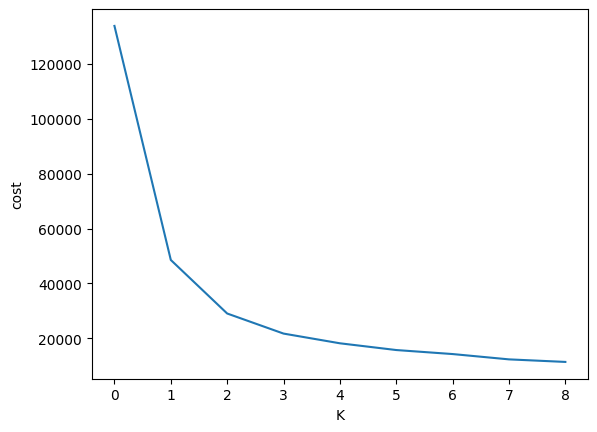

In [42]:
cost = []
for clusters in range(1,10):
    try:
        kproto = KPrototypes(n_clusters=clusters, max_iter=20)
        kproto.fit_predict(df_analysis_matrix, categorical=[0,1,2,3,4,5,6])
        cost.append(kproto.cost_)
        print(f'{clusters} clusters.')
    except Exception as e:
        print(e)
plt.plot(cost)
plt.xlabel('K')
plt.ylabel('cost')
plt.show

In [51]:
kproto = KPrototypes(n_clusters=3, max_iter=20)
labels = kproto.fit_predict(df_analysis_matrix, categorical=[0,1,2,3,4,5,6])
df_analysis['label'] = labels
df_analysis['latitude'] = df_raw['latitude'] 
df_analysis['longitude']= df_raw['longitude']
df_analysis['school_name']= df_raw['Nom_etablissement']

In [52]:
df_analysis

,public_private_status,has_catering_service,has_lodging_service,has_inclusive_education,main_denomination,REP,REP +,distance,rent_index,age,density,label,latitude,longitude,school_name
0,0,1,0,0,9,0,0,1.223922,27.896875,54.633864,23.875000,0,48.845869,2.350652,E.P.PR SAINTE-GENEVIEVE 65 rue du Cardinal Lem...
1,0,1,0,0,9,0,0,1.596907,24.637500,54.620167,24.750000,0,48.867955,2.377510,E.P.PR SAINT-PAUL 81 rue Jean-Pierre Timbaud
2,0,1,0,0,9,0,0,1.390192,21.478125,42.692912,10.800000,1,48.829957,2.372396,E.P.PR BETH MYRIAM 19 rue de Domrémy
3,0,1,0,0,9,0,0,2.026350,24.637500,34.598049,17.666667,1,48.870403,2.377842,E.P.PR OZAR HATORAH 38 rue Moulin Joly
4,0,1,0,0,1,0,0,1.311856,28.956250,54.633864,28.750000,0,48.853545,2.365784,E.E.PR LES FRANCS BOURGEOIS 21 rue Saint Antoine
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
765,1,1,0,0,5,0,0,4.795224,24.992118,52.269780,19.000000,0,48.896240,2.075476,Ecole maternelle Marcel Aymé
766,1,1,0,0,5,0,0,4.762391,24.992118,47.930604,20.000000,1,48.892990,2.064831,Ecole maternelle Beethoven
767,1,0,0,0,5,0,0,4.066824,24.992118,43.955766,24.666667,1,48.901126,2.068536,Ecole maternelle Passy
768,1,1,0,0,5,0,0,4.596927,24.992118,58.332025,29.000000,0,48.900927,2.080686,Ecole maternelle Ampère


In [91]:
m = folium.Map(location=[48.85422002028079, 2.3484716894925914], zoom_start=12)
layer_control = folium.LayerControl().add_to(m)
feature_group_0 = folium.FeatureGroup(name='Label 0')
feature_group_1 = folium.FeatureGroup(name='Label 1')
feature_group_2 = folium.FeatureGroup(name='Label 2')

for latitude, longitude, school_name, label in zip(
    df_analysis.latitude.values, 
    df_analysis.longitude.values, 
    df_analysis.school_name.values,
    df_analysis.label
):
    icon = folium.Icon(
        color='blue' if label==0 else 'green' if label == 1 else 'purple',
        icon='school',
        prefix='fa'
    )
    mk = folium.Marker(
        location=(latitude, longitude),
        tooltip=school_name,
        popup=label,
        icon=icon
    )
    if label == 0:
        feature_group_0.add_child(mk)
    if label == 1:
        feature_group_1.add_child(mk)
    if label == 2:
        feature_group_2.add_child(mk)
m.add_child(feature_group_0)
m.add_child(feature_group_1)
m.add_child(feature_group_2)

m

In [82]:
df_analysis[df_analysis['label']==0].describe()

,public_private_status,has_catering_service,has_lodging_service,has_inclusive_education,main_denomination,REP,REP +,distance,rent_index,age,density,label,latitude,longitude
count,543.000000,543.000000,543.000000,543.000000,543.000000,543.000000,543.000000,543.000000,543.000000,543.000000,543.000000,543.0,543.000000,543.000000
mean,0.834254,0.998158,0.007366,0.125230,4.381215,0.220994,0.033149,1.152590,25.293776,57.442075,21.211754,0.0,48.861811,2.339231
std,0.372195,0.042914,0.085590,0.331285,2.804217,0.415299,0.179191,0.705284,2.480684,1.802853,4.251123,0.0,0.021794,0.060624
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.036550,21.478125,49.313990,1.750000,0.0,48.820889,2.062406
25%,1.000000,1.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.565329,24.121875,58.332025,17.878571,0.0,48.843591,2.316763
50%,1.000000,1.000000,0.000000,0.000000,5.000000,0.000000,0.000000,1.067173,25.156250,58.332025,21.600000,0.0,48.860751,2.349694
75%,1.000000,1.000000,0.000000,0.000000,5.000000,0.000000,0.000000,1.679347,26.271875,58.332025,24.000000,0.0,48.880262,2.377472
max,1.000000,1.000000,1.000000,1.000000,10.000000,1.000000,1.000000,4.870546,31.431250,58.332025,42.714286,0.0,48.901052,2.413005


In [83]:
df_analysis[df_analysis['label']==1].describe()

,public_private_status,has_catering_service,has_lodging_service,has_inclusive_education,main_denomination,REP,REP +,distance,rent_index,age,density,label,latitude,longitude
count,161.000000,161.000000,161.0,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.0,161.000000,161.000000
mean,0.950311,0.956522,0.0,0.043478,4.701863,0.298137,0.031056,1.206042,24.329384,41.734776,19.938507,1.0,48.862174,2.342926
std,0.217981,0.204567,0.0,0.204567,2.363379,0.458867,0.174010,0.813950,2.327793,4.824250,3.429751,0.0,0.023318,0.064879
min,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.155108,21.478125,30.979330,10.800000,1.0,48.820577,2.064468
25%,1.000000,1.000000,0.0,0.000000,2.000000,0.000000,0.000000,0.596756,21.478125,37.983921,17.142857,1.0,48.841379,2.318991
50%,1.000000,1.000000,0.0,0.000000,5.000000,0.000000,0.000000,1.027720,24.637500,42.986026,20.600000,1.0,48.861266,2.364384
75%,1.000000,1.000000,0.0,0.000000,5.000000,1.000000,0.000000,1.690351,26.237500,44.988512,22.571429,1.0,48.885547,2.382206
max,1.000000,1.000000,0.0,1.000000,10.000000,1.000000,1.000000,4.859879,31.431250,49.785164,27.000000,1.0,48.901126,2.410733


In [84]:
df_analysis[df_analysis['label']==2].describe()

,public_private_status,has_catering_service,has_lodging_service,has_inclusive_education,main_denomination,REP,REP +,distance,rent_index,age,density,label,latitude,longitude
count,66.000000,66.000000,66.0,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.0,66.000000,66.000000
mean,0.818182,0.909091,0.0,0.136364,7.166667,0.257576,0.045455,1.117429,24.126964,18.958189,19.723395,2.0,48.870071,2.346749
std,0.388650,0.289683,0.0,0.345804,2.964318,0.440650,0.209895,0.750032,2.021747,7.739142,4.038410,0.0,0.024815,0.049113
min,0.000000,0.000000,0.0,0.000000,2.000000,0.000000,0.000000,0.140105,21.478125,1.963832,9.875000,2.0,48.817846,2.070564
25%,1.000000,1.000000,0.0,0.000000,5.000000,0.000000,0.000000,0.553547,21.478125,13.220623,16.534091,2.0,48.844309,2.327845
50%,1.000000,1.000000,0.0,0.000000,9.000000,0.000000,0.000000,0.961803,24.637500,20.903895,20.166667,2.0,48.878925,2.356918
75%,1.000000,1.000000,0.0,0.000000,10.000000,0.750000,0.000000,1.648497,25.728125,24.977351,22.000000,2.0,48.889041,2.379104
max,1.000000,1.000000,0.0,1.000000,10.000000,1.000000,1.000000,4.521117,28.712500,29.979456,30.000000,2.0,48.899691,2.405538
